<span style="font-size: 30px;">Taller Machine learning I</span>

<span style="font-size: 20px;">Integrantes</span>

* Nombre: Maria del mar Ipia Guzmán
* Cédula: 1214726595
* Correo: maria.ipia@udea.edu.co

  

- Nombre: Johan Arbey Vargas Mejía
- Cédula: 1152195956
- Correo: johan.vargas@udea.edu.co

# Dataset youtube

Este conjunto de datos contiene información sobre videos de YouTube, segmentado por regiones, durante un período de tiempo específico. El conjunto de datos contiene 23 columnas que representan diferentes atributos de los videos.

Algunas de las columnas clave incluyen:

* video_id: ID único para identificar cada video.
* trending_date: Fecha en la que el video se volvió popular (trending).
* title: Título del video.
* channel_title: Nombre del canal que publicó el video.
* category_id: ID que representa la categoría del video.
* publish_time: Fecha y hora en que se publicó el video.
* views: Número de vistas que ha recibido el video.
* likes: Número de "me gusta" que ha recibido el video.
* dislikes: Número de "no me gusta" que ha recibido el video.
* comment_count: Número de comentarios que ha recibido el video.
* tags: Etiquetas asociadas al video.
* thumbnail_link: Enlace a la miniatura del video.

Los datos abarcan desde el 14 de noviembre de 2017 hasta el 14 de junio de 2018.

# Librerías

In [3]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import zipfile

from nltk.corpus import stopwords
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


%matplotlib inline
plt.style.use('ggplot')

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Configuración del API de Kaggle

1. Iniciar sesión en tu cuenta de Kaggle en `https://www.kaggle.com`.
2. Hacer clic en tu foto de perfil en la esquina superior derecha de la página y seleccionar "Cuenta" en el menú desplaable.
3. Desplazar hacia abajo hasta la sección `API` y haz clic en `Crear nueva clave de API`.
4. Se descargará automáticamente el archivo `kaggle.json` que contiene las credenciales de API de Kaggle.
5. Guardar el archivo kaggle.json en una `input`.

In [5]:
def set_environ_kaggle(path: str) -> None:
    """Establece las variables de entorno para la autenticación 
     de la API de Kaggle.

    Args:
        path: Ruta al archivo kaggle.json que contiene las 
         credenciales de API de Kaggle.

    """
    with open(path, 'r') as f:
        data = json.load(f)

    os.environ['KAGGLE_USERNAME'] = data['username']
    os.environ['KAGGLE_KEY'] = data['key']

In [6]:
kaggle_path = os.path.join('..', 'input', 'kaggle.json')

In [7]:
# Se configura el entorno para autenticarse en KAGGLE.
set_environ_kaggle(kaggle_path)

## Descargar el conjunto de datos

In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [9]:
def download_dataset(dataset_name: str, output_path: str) -> None:
    """Descarga un conjunto de datos de Kaggle y lo extrae en 
     la ubicación especificada.

    Args:
        dataset_name: Nombre del conjunto de datos en Kaggle.
         Debe seguir el formato 'nombre-usuario/nombre-conjunto-datos'.
        output_path: Ruta donde se extraerán los archivos 
         del conjunto de datos.

    """
    api = KaggleApi()
    api.authenticate()

    api.dataset_download_files(dataset_name)

    file_name = dataset_name.split('/')[1]
    with zipfile.ZipFile(f'{file_name}.zip', 'r') as zip_ref:
        zip_ref.extractall(output_path)

    os.remove(f'{file_name}.zip')

El dataset se encuentra en el link: https://www.kaggle.com/datasets/datasnaek/youtube-new?select=MXvideos.csv

Notar que el nombre del conjunto de datos está despues `datasets/` y va hasta el signo `?`

In [10]:
dataset_name = 'datasnaek/youtube-new'

In [11]:
data_path = os.path.join('..', 'data')

In [12]:
download_dataset(dataset_name, data_path)

# Funciones utils

## Gráficas

In [13]:
def pie_plot(data: pd.DataFrame, col: str) -> None:
    """Genera un gráfico de pastel basado en una columna de un DataFrame.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        col (str): El nombre de la columna a graficar.

    Returns:
        None: Muestra el gráfico de pastel.

    """
    plt.figure(figsize=(8, 5))
    datos = data[col]
    labels = data.index
    
    # Se agregan colores con plt.cm estableciendo un color para cada espacio en el 
    # diagrama, por eso se usa un linspace de la misma magnitud de los datos.
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.7, len(datos)))
    
    # Generación del diagrama circular
    patches, texts = plt.pie(datos, labels=labels, colors=colors)

    # Para que siempre se vea como un círculo
    plt.axis('equal')
    
    # Se eliminan las líneas
    plt.rcParams['patch.linewidth'] = 0
    
    # Estimación porcentaje
    porcent = 100 * datos / sum(datos)
    # Lista que será expuesta en la legenda
    labels = ['{0} - {1:1.1f} %'.format(i,j) for i, j in zip(labels, porcent)]
    
    # Se genera la legenda
    # bbox_to_anchor especifica en coordenadas la posición de la legenda
    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
    
    plt.show()

In [14]:
def box_plot(df: pd.DataFrame, showfliers: bool = True):
    """Genera un diagrama de cajas utilizando el mapa de colores RdYlGn.

    Args:
        df (pd.DataFrame): El DataFrame que se utilizará para generar 
         el diagrama de cajas.
        showfliers (bool): Indica si se muestran o no los valores 
         atípicos en el diagrama de cajas. Valor predeterminado es True.

    Returns:
        None: Muestra el gráfico de barras.
        
    """
    # Generar el diagrama de cajas utilizando df.plot(kind='box')
    ax = df.plot(kind='box', patch_artist=True, figsize=(8, 5), showfliers=showfliers, vert=False)
    
    # Configurar el mapa de colores
    cmap = plt.cm.RdYlGn
    
    # Personalizar el color de las cajas utilizando el mapa de colores
    for patch, color in zip(ax.artists, cmap(np.linspace(0.1, 0.9, len(ax.artists)))):
        patch.set_facecolor(color)

    plt.show()

## Limpieza

In [15]:
def find_missing(df: pd.DataFrame) -> pd.DataFrame:
    """Encuentra los valores faltantes en un DataFrame y devuelve un nuevo DataFrame
     que muestra la cantidad de valores faltantes y el porcentaje correspondiente.

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame que muestra las columnas, la cantidad de
        valores faltantes y el porcentaje de valores faltantes para cada columna.

    """
    lista = []
    for col in df.columns:
        num = df[df[col].isnull()].shape[0]
        lista.append(num)
    
    dic = {
        'Columnas': df.columns,
        'Faltantes': lista}
    df_faltantes = pd.DataFrame(dic)
    
    df_faltantes['Porcentaje'] = df_faltantes['Faltantes'] / df.shape[0]
    
    return df_faltantes

In [16]:
def clean_text(df: pd.DataFrame,  column: str) -> pd.DataFrame:
    """Limpia el texto en una columna específica de un DataFrame, 
     eliminando stopwords y filtrando palabras por longitud.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        columna (str): Nombre de la columna que contiene el texto a limpiar.
        
    Returns:
        pd.DataFrame: DataFrame con el texto limpio.
    """
    # Se descargan las stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english')) 

    # Se eliminan todas las stopwords de las frases
    len_min = 3
    len_max = 10 
    list_words = []
    for string in df[column]:
        string = re.sub(r'\d+', '', string)
        words = string.split() 
        words_stopwords = [word for word in words 
                           if word not in stop_words
                           and len_min <= len(word) <= len_max]
        clean_word = ' '.join(words_stopwords)
        list_words.append(clean_word)

    df[column] = list_words

    return df   

# Exploración de datos

## Lectura de datos

Archivo JSON con la información de las categorías de los videos.

In [17]:
with open(os.path.join(data_path, 'US_category_id.json'), 'r') as f:
    data = json.load(f)

In [18]:
ls = []
for diccionario in data['items']:
    row = {
        'category_id': diccionario['id'],
        'category': diccionario['snippet']['title']
    }
    
    ls.append(row)

categories = pd.DataFrame(ls)

In [19]:
categories.head()

,category_id,category
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [20]:
path = os.path.join(data_path, 'USvideos.csv')
youtube = pd.read_csv(path, encoding='latin-1', converters={'category_id': str})

In [21]:
print(f'Tamaño del dataset: {youtube.shape}')

Tamaño del dataset: (40949, 16)


In [22]:
youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  object
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

## Imputación

In [23]:
missing_values = find_missing(youtube)

In [24]:
missing_values

,Columnas,Faltantes,Porcentaje
0,video_id,0,0.00000
1,trending_date,0,0.00000
2,title,0,0.00000
3,channel_title,0,0.00000
4,category_id,0,0.00000
5,publish_time,0,0.00000
6,tags,0,0.00000
7,views,0,0.00000
8,likes,0,0.00000
9,dislikes,0,0.00000


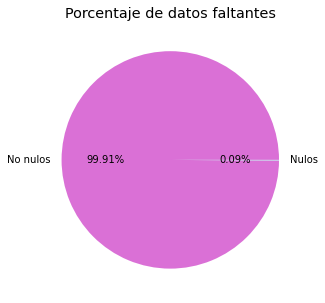

In [25]:
total_faltantes = missing_values['Faltantes'].sum()
total_registros = youtube.shape[0] * youtube.shape[1]

plt.figure(figsize=(5, 5))
datos = [total_registros - total_faltantes, total_faltantes]
label = ['No nulos', 'Nulos']

plt.pie(
    datos, 
    labels=label, 
    colors=['orchid', 'lightblue'], 
    autopct='%.2f%%')
plt.title('Porcentaje de datos faltantes')
plt.show()

No se encontraron valores nulos en las columnas, a excepción de la columna `description` que no será usada en el modelo de clasificación por lo que no hay necesidad de realizar imputación de datos.

## Datos atípicos

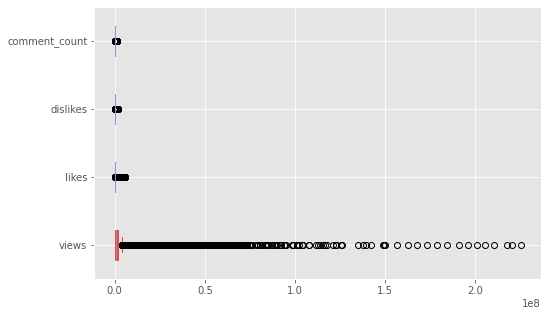

In [26]:
box_plot(youtube)

* Se seleccionan las columnas numéricas para escalar y tener un diagrama de cajas con las caracteríscas en la misma escala

In [27]:
youtube_numeric = youtube.select_dtypes(include=['float64', 'int64'])

In [28]:
youtube_numeric

,views,likes,dislikes,comment_count
0,748374,57527,2966,15954
1,2418783,97185,6146,12703
2,3191434,146033,5339,8181
3,343168,10172,666,2146
4,2095731,132235,1989,17518
...,...,...,...,...
40944,1685609,38160,1385,2657
40945,1064798,60008,382,3936
40946,1066451,48068,1032,3992
40947,5660813,192957,2846,13088


In [29]:
# Normalización de los datos

min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(youtube_numeric)

numeric_scale = pd.DataFrame(numeric_scale, columns=youtube_numeric.columns)

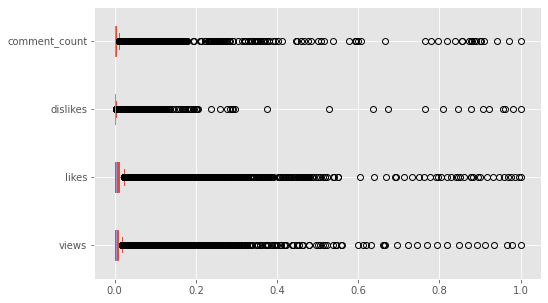

In [30]:
box_plot(numeric_scale)

* Observemos los datos sin presencia de outliers para intentar tener una vista clara de los datos

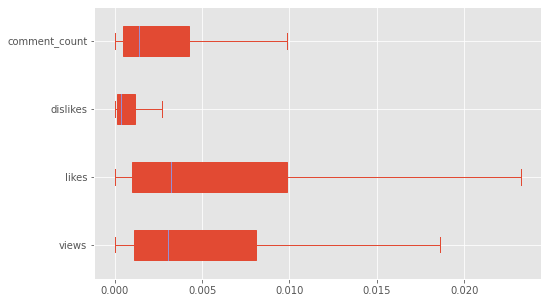

In [31]:
box_plot(numeric_scale, showfliers=False)

## Detección de outliers con el algoritmo LOF

In [32]:
lof = LocalOutlierFactor(
    n_neighbors=5, 
    algorithm='auto', 
    contamination='auto', 
    metric='euclidean')

In [33]:
lof_array = lof.fit_predict(numeric_scale)

In [34]:
ground_truth = np.ones(len(numeric_scale), dtype=int)

In [35]:
n_errors = (lof_array != ground_truth).sum()

In [36]:
n_errors

3413

Partiendo del algoritmo LOF, se encontraron $3413$ datos atípicos, los cuales se deciden eliminar del dataframe para minimizar el ruido e el modelo.

In [37]:
pos = np.where(lof_array == ground_truth)
pos = np.asarray(pos)
pos = np.hstack(pos)
youtube = youtube.loc[pos, :]
print('Número de muestras sin outilers:', youtube.shape[0])

Número de muestras sin outilers: 37536


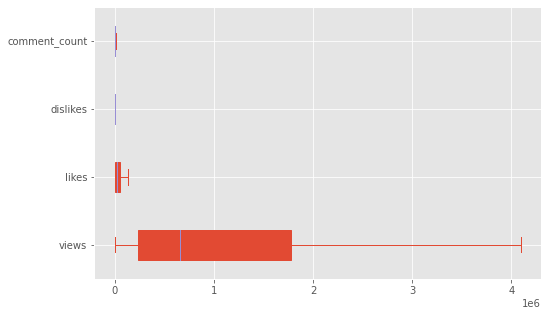

In [38]:
box_plot(youtube, showfliers=False)

# Transformaciones

In [39]:
youtube = pd.merge(
    youtube,
    categories,
    on='category_id',
    how='left')

In [40]:
categories_youtube = youtube.groupby('category').agg({'video_id': 'count'})

In [41]:
categories_youtube['per'] = categories_youtube['video_id'] / categories_youtube['video_id'].sum() * 100

In [42]:
categories_youtube = categories_youtube.sort_values(by='video_id', ascending=False)

In [43]:
categories_youtube

,video_id,per
category,,
Entertainment,9109,24.267370
Music,5939,15.822144
Howto & Style,3877,10.328751
Comedy,3213,8.559783
People & Blogs,2951,7.861786
Science & Technology,2219,5.911658
News & Politics,2167,5.773124
Film & Animation,2133,5.682545
Sports,1959,5.218990


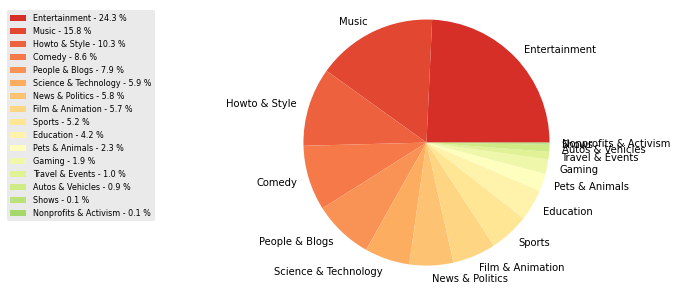

In [44]:
pie_plot(categories_youtube, 'video_id')

## Agrupación de categorias de bajo porcentaje de participación

In [45]:
cats = ['Education', 'Pets & Animals', 'Gaming', 'Travel & Events',
        'Autos & Vehicles', 'Nonprofits & Activism', 'Shows']

for cat in cats:
    cond = youtube['category'] == cat
    youtube.loc[cond, 'category'] = 'Other'

In [46]:
ids = categories[categories['category'].isin(cats)]['category_id'].unique()

for id in ids:
    cond = youtube['category_id'] == id
    youtube.loc[cond, 'category_id'] = '50'

In [47]:
categories_youtube = youtube.groupby('category').agg({'video_id': 'count'})

In [48]:
categories_youtube

,video_id
category,
Comedy,3213
Entertainment,9109
Film & Animation,2133
Howto & Style,3877
Music,5939
News & Politics,2167
Other,3969
People & Blogs,2951
Science & Technology,2219


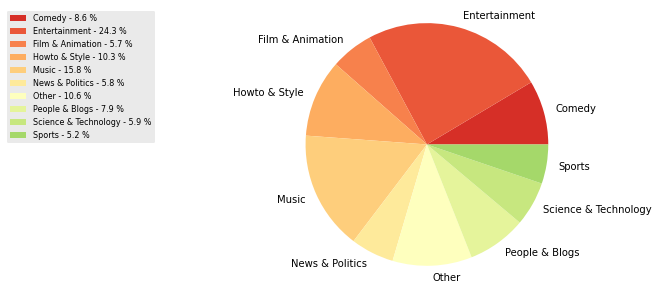

In [49]:
pie_plot(categories_youtube, 'video_id')

## Características

* Cantidad de días para convertirse en tendencia

In [50]:
youtube['trending_date'] = pd.to_datetime(youtube['trending_date'], format='%y.%d.%m')

In [51]:
youtube['publish_time'] = pd.to_datetime(youtube['publish_time'])

In [52]:
youtube['days'] = (youtube['trending_date'] - youtube['publish_time'].dt.tz_localize(None)).dt.days

* Longitud del titulo del video

In [53]:
youtube['title_length'] = youtube['title'].apply(lambda x: len(x))

* Cantidad de tags con las que cuenta el video

In [54]:
youtube['tag_count'] = youtube['tags'].apply(lambda x: len(x.split('|')))

In [63]:
youtube.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,days,title_length,tag_count
0,1ZAPwfrtAFY,2017-11-14,the trump presidency: last week tonight with john oliver (hbo),LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",Entertainment,0,62,4
1,puqaWrEC7tY,2017-11-14,nickelback lyrics: real or fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""rhett and link good mythical morning""|""good mythical morning rhett and link""|""mythical morning""|""Season 12""|""nickelback lyrics""|""nickelback lyrics real or fake""|""nickelback""|""nickelback songs""|""nickelback song""|""rhett link nickelback""|""gmm nickelback""|""lyrics (website category)""|""nickelback (musical group)""|""rock""|""music""|""lyrics""|""chad kroeger""|""canada""|""music (industry)""|""mythical""|""gmm challenge""|""comedy""|""funny""|""challenge""",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amateur or a secret Nickelback devotee. GMM #1218\nDon't miss an all new Ear Biscuits: https://goo.gl/xeZNQt\nWatch Part 4: https://youtu.be/MhCdiiB8CQg | Watch Part 2: https://youtu.be/7qiOrNao9fg\nWatch today's episode from the start: http://bit.ly/GMM1218\n\nPick up all of the official GMM merch only at https://mythical.store\n\nFollow Rhett & Link: \nInstagram: https://instagram.com/rhettandlink\nFacebook: https://facebook.com/rhettandlink\nTwitter: https://twitter.com/rhettandlink\nTumblr: https://rhettandlink.tumblr.com\nSnapchat: @realrhettlink\nWebsite: https://mythical.co/\n\nCheck Out Our Other Mythical Channels:\nGood Mythical MORE: https://youtube.com/goodmythicalmore\nRhett & Link: https://youtube.com/rhettandlink\nThis Is Mythical: https://youtube.com/thisismythical\nEar Biscuits: https://applepodcasts.com/earbiscuits\n\nWant to send us something? https://mythical.co/contact\nHave you made a Wheel of Mythicality intro video? Submit it here: https://bit.ly/GMMWheelIntro\n\nIntro Animation by Digital Twigs: https://www.digitaltwigs.com\nIntro & Outro Music by Jeff Zeigler & Sarah Schimeneck https://www.jeffzeigler.com\nWheel of Mythicality theme: https://www.royaltyfreemusiclibrary.com/\nAll Supplemental Music fromOpus 1 Music: https://opus1.sourceaudio.com/\nWe use âThe Mouseâ by Blue Microphones https://www.bluemic.com/mouse/,Entertainment,0,32,27


* Vectorizar el titulo

### Ejemplo de vectorización

In [55]:
titles = [
    'WE WANT TO TALK ABOUT OUR MARRIAGE',
    'The Trump Presidency: Last Week Tonight with John Oliver (HBO)',
    'Racist Superman | Rudy Mancuso, King Bach & Lele Pons',
    'Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs',
    'Carla Makes BA Smashburgers | From the Test Kitchen | Bon Appétit',
    'Katherine Langford on 13 Reasons Why, Australia & Doctor Parents'
]

df = pd.DataFrame({'titulo': titles})
df

,titulo
0,WE WANT TO TALK ABOUT OUR MARRIAGE
1,The Trump Presidency: Last Week Tonight with John Oliver (HBO)
2,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons"
3,Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs
4,Carla Makes BA Smashburgers | From the Test Kitchen | Bon Appétit
5,"Katherine Langford on 13 Reasons Why, Australia & Doctor Parents"


* Instanciamos la clase CountVectorizer

In [56]:
vectorizer_example = CountVectorizer()

In [57]:
X = vectorizer_example.fit_transform(df['titulo'])

In [58]:
cols = vectorizer_example.get_feature_names_out()
cols

array(['13', 'about', 'appétit', 'ashton', 'australia', 'ba', 'bach',
       'bon', 'carla', 'combs', 'diddy', 'doctor', 'drop', 'from', 'hbo',
       'john', 'katherine', 'king', 'kitchen', 'kutcher', 'langford',
       'last', 'lele', 'makes', 'mancuso', 'marriage', 'mic', 'oliver',
       'on', 'our', 'parents', 'pons', 'presidency', 'racist', 'reasons',
       'rudy', 'sean', 'smashburgers', 'superman', 'talk', 'test', 'the',
       'to', 'tonight', 'trump', 'want', 'we', 'week', 'why', 'with'],
      dtype=object)

In [59]:
X_vectorizer = pd.DataFrame(X.toarray(), columns=cols)
X_vectorizer

,13,about,appétit,ashton,australia,ba,bach,bon,carla,combs,diddy,doctor,drop,from,hbo,john,katherine,king,kitchen,kutcher,langford,last,lele,makes,mancuso,marriage,mic,oliver,on,our,parents,pons,presidency,racist,reasons,rudy,sean,smashburgers,superman,talk,test,the,to,tonight,trump,want,we,week,why,with
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


* Continuamos con la vectorización del título

In [60]:
youtube['title'] = youtube['title'].str.lower()

* Con la función `clean_text` se eliminan las stopswords, palabras cortas y largas y caracteres extraños.

In [64]:
youtube = clean_text(youtube, 'title')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mdmgu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [65]:
patron_caracteres_otros_idiomas = re.compile(r'[^\x00-\x7F]+')

mascara = youtube['title'].apply(lambda x: not re.search(patron_caracteres_otros_idiomas, x))

In [66]:
youtube = youtube[mascara]

In [67]:
vectorizer = CountVectorizer()

x_title = vectorizer.fit_transform(youtube['title'])

### Elección de características

In [68]:
youtube.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'category', 'days',
       'title_length', 'tag_count'],
      dtype='object')

In [69]:
columnas = ['views', 'likes', 'dislikes', 'comment_count', 
            'days','title_length', 'tag_count', 'category', ]

In [70]:
youtube_model = youtube.loc[:, columnas]

In [72]:
youtube_model.head()

,views,likes,dislikes,comment_count,days,title_length,tag_count,category
0,2418783,97185,6146,12703,0,62,4,Entertainment
1,343168,10172,666,2146,0,32,27,Entertainment
2,2095731,132235,1989,17518,1,24,14,Entertainment
3,817732,23663,778,3432,1,35,13,Science & Technology
4,826059,3543,119,340,0,65,28,Film & Animation


### Exportación de datos del modelo en parquet

In [76]:
path = os.path.join('..', 'data', 'youtube_model.parquet')
youtube_model.to_parquet(path, index=False)

# Modelo de clasificación

* Aplicamos LabelEncoder para cambiar categorias en el modelo

In [77]:
#le = LabelEncoder()
#y_encoded = le.fit_transform(youtube_model['category'])

In [78]:
#for i, categoria in enumerate(le.classes_):
#    print(f"Número: {i}, Categoría: {categoria}")

In [79]:
x_model = youtube_model.drop('category', axis=1)

* Escalamos los datos

In [80]:
min_max = MinMaxScaler()

x = min_max.fit_transform(x_model)

x = pd.DataFrame(x, columns=x_model.columns)

## División del conjunto de datos

In [ ]:
x_numeric = np.array(x)

X = np.hstack((x_title.toarray(), x_numeric))

In [81]:
y = youtube_model['category']

In [82]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=1234, shuffle=True
)

In [83]:
print("Tamaño del conjunto de entrenamiento:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print("Tamaño del conjunto de prueba:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Tamaño del conjunto de entrenamiento:
x_train: (27735, 7)
y_train: (27735,)
Tamaño del conjunto de prueba:
x_test: (6934, 7)
y_test: (6934,)


## Entrenamiento y testeo

### Random Forest

* Usamos GridSearchCV para buscar el mejor modelo

In [84]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [5, 7, 9],
    'max_depth': [None, 5, 10],
    'criterion': ['gini', 'entropy']}

In [85]:
rf = RandomForestClassifier(random_state=1234)

In [86]:
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy')

In [87]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10], 'max_features': [5, 7, 9],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [88]:
params = grid_search.best_params_
rf_model = grid_search.best_estimator_

In [89]:
importancia = pd.DataFrame({
    'predictor': x.columns,
    'importancia': rf_model.feature_importances_
})
importancia.sort_values('importancia', ascending=False)

,predictor,importancia
5,title_length,0.174663
1,likes,0.169750
6,tag_count,0.167410
3,comment_count,0.163127
2,dislikes,0.142583
0,views,0.132432
4,days,0.050035


In [90]:
rf_model.feature_importances_

array([0.1324322 , 0.16974994, 0.14258323, 0.16312723, 0.05003476,
       0.17466274, 0.1674099 ])

In [91]:
resultados = pd.DataFrame(grid_search.cv_results_)
resultados = resultados.filter(regex = '(param*|mean_t|std_t)')
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('mean_test_score', ascending=False)
resultados

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score
2,gini,None,5,200,0.889490,0.002320
29,entropy,None,5,200,0.889057,0.002968
28,entropy,None,5,100,0.888156,0.002884
35,entropy,None,9,200,0.887543,0.003906
32,entropy,None,7,200,0.887543,0.003906
1,gini,None,5,100,0.885740,0.001497
27,entropy,None,5,50,0.885416,0.003254
34,entropy,None,9,100,0.885416,0.001930
31,entropy,None,7,100,0.885416,0.001930
5,gini,None,7,200,0.884983,0.002300


In [92]:
print(f'Los mejores parametros para el RandomForest son: {params}')

Los mejores parametros para el RandomForest son: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200}


In [93]:
y_pred = rf_model.predict(x_test)

In [94]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Exactitud del modelo: {:.2f}%".format(accuracy * 100))

Exactitud del modelo: 91.16%


* Cross validation

In [95]:
scores = cross_val_score(rf_model, x_train, y_train, cv=5)

In [96]:
for i, j in enumerate(scores):
    print(f'fold {i+1}: {j}')

fold 1: 0.8907517577068685
fold 2: 0.8857039841355687
fold 3: 0.8907517577068685
fold 4: 0.8921939787272399
fold 5: 0.8880475932936722


In [97]:
print(f'mean acc: {scores.mean()}')

mean acc: 0.8894898143140436


### DecisionTreeClassifier

In [98]:
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [99]:
dt = DecisionTreeClassifier(random_state=1234)

In [100]:
grid_search_tree = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy')

In [101]:
grid_search_tree.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [102]:
params_dt = grid_search_tree.best_params_
dt_model = grid_search_tree.best_estimator_

In [103]:
y_pred = dt_model.predict(x_test)

In [104]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Exactitud del modelo: {:.2f}%".format(accuracy * 100))

Exactitud del modelo: 79.77%
